# Benchmark: Dataclasses vs Pydantic v2 vs Msgspec

This notebook benchmarks instantiation, encoding, and decoding performance.

In [2]:
from benchmark_dataclass import instantiate_dataclass, encode_dataclass, decode_dataclass
from benchmark_pydantic import instantiate_pydantic, encode_pydantic, decode_pydantic
from benchmark_msgspec import instantiate_msgspec, encode_msgspec, decode_msgspec
from data_generator import generate_users_batch
from time import perf_counter
import statistics
import matplotlib.pyplot as plt


In [9]:
def micro_benchmark(fn, obj, iterations=1_000_000):
    times = []
    for _ in range(iterations):
        start = perf_counter()
        fn(obj)
        end = perf_counter()
        times.append(end - start)
    return statistics.mean(times) * 1e6

def batch_benchmark(fn, batch):
    start = perf_counter()
    for item in batch:
        fn(item)
    end = perf_counter()
    avg = (end - start) / len(batch) * 1e6
    total = end - start
    return avg, total

In [10]:
sample = generate_users_batch(1)[0]
dc_obj = instantiate_dataclass(sample)
py_obj = instantiate_pydantic(sample)
ms_obj = instantiate_msgspec(sample)

dc_encoded = encode_dataclass(dc_obj)
py_encoded = encode_pydantic(py_obj)
ms_encoded = encode_msgspec(ms_obj)

results_micro = {
    'instantiate': {
        'dataclass': micro_benchmark(instantiate_dataclass, sample),
        'pydantic': micro_benchmark(instantiate_pydantic, sample),
        'msgspec': micro_benchmark(instantiate_msgspec, sample)
    },
    'encode': {
        'dataclass': micro_benchmark(lambda _ : encode_dataclass(dc_obj), None),
        'pydantic': micro_benchmark(lambda _ : encode_pydantic(py_obj), None),
        'msgspec': micro_benchmark(lambda _ : encode_msgspec(ms_obj), None)
    },
    'decode': {
        'dataclass': micro_benchmark(lambda _ : decode_dataclass(dc_encoded), None),
        'pydantic': micro_benchmark(lambda _ : decode_pydantic(py_encoded), None),
        'msgspec': micro_benchmark(lambda _ : decode_msgspec(ms_encoded), None)
    }
}
results_micro

{'instantiate': {'dataclass': 0.24908511806279418,
  'pydantic': 0.8020774321630597,
  'msgspec': 0.1595888016745448},
 'encode': {'dataclass': 2.8314524851739407,
  'pydantic': 0.7387783089652658,
  'msgspec': 0.13831927347928286},
 'decode': {'dataclass': 1.4338372396305203,
  'pydantic': 0.9436456691473722,
  'msgspec': 0.2389183398336172}}

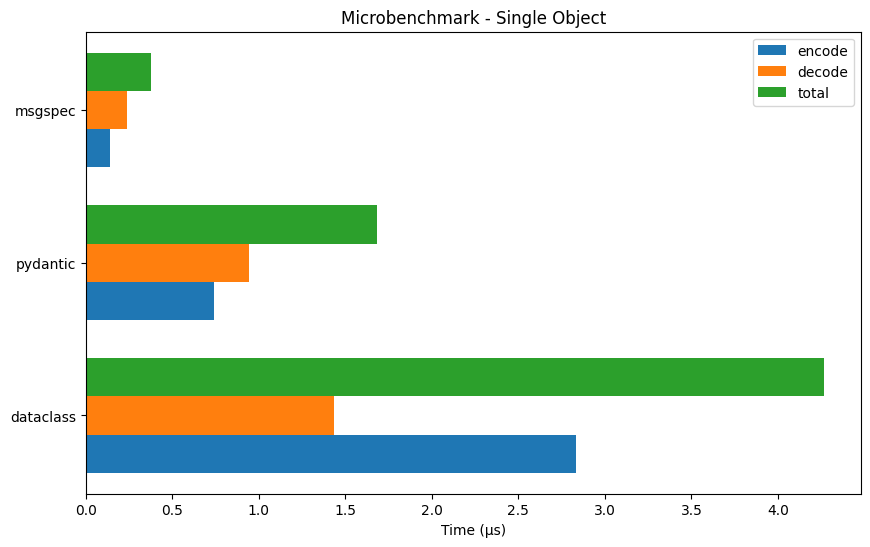

In [11]:
import numpy as np

labels = ['dataclass', 'pydantic', 'msgspec']
encode_vals = [results_micro['encode'][l] for l in labels]
decode_vals = [results_micro['decode'][l] for l in labels]
total_vals = [encode_vals[i] + decode_vals[i] for i in range(3)]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10,6))
plt.barh(x - width, encode_vals, height=0.25, label='encode')
plt.barh(x, decode_vals, height=0.25, label='decode')
plt.barh(x + width, total_vals, height=0.25, label='total')

plt.yticks(x, labels)
plt.xlabel('Time (µs)')
plt.title('Microbenchmark - Single Object')
plt.legend()
plt.show()

In [12]:
encode_vals

[2.8314524851739407, 0.7387783089652658, 0.13831927347928286]